## Setup

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import KFold
import logging
import math
from scipy.stats import skew, kurtosis, iqr

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Load dataset
df = pd.read_feather("../Data/Data1.feather")

print(df.info())
print(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           21365 non-null  object
 1   company_names  21365 non-null  object
 2   sentiment      21365 non-null  int64 
 3   base_url       21365 non-null  object
dtypes: int64(1), object(3)
memory usage: 667.8+ KB
None
                                                                   text  \
13177              make sens rig outperform slb much ytd last mo recent   
5182   autozon inc azo stake lift caiss de depot et placement du quebec   
17116      price decentraland mana hurri binanc current accept new user   
15157                current wave price quick sign binanc close registr   
15680             ntr report earn consensu earn whisper via whisperbeat   

                   company_names  sentiment     base_url  
13177             transocean ltd          0  twitter.com  
5182    

## Text Preprocessing

In [4]:
# Select relevant features and target variable
X = df[['text', 'company_names', 'base_url']]
Y = df['sentiment']

# Encode target labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

In [5]:
# Concatenate textual features with a unique delimiter for clarity
delimiter = ' <EOF> '
X_train_combined = X_train['text'] + delimiter + X_train['company_names'] + delimiter + X_train['base_url']
X_test_combined = X_test['text'] + delimiter + X_test['company_names'] + delimiter + X_test['base_url']

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_combined)
X_train_seq = tokenizer.texts_to_sequences(X_train_combined)
X_test_seq = tokenizer.texts_to_sequences(X_test_combined)

In [6]:
# Analyze the distribution of token lengths to determine padding length
token_lengths = [len(tokens) for tokens in X_train_seq]

# Adjusted descriptive statistics
max_length = np.max(token_lengths)
min_length = np.min(token_lengths)
median_length = np.median(token_lengths)
iqr_length = iqr(token_lengths)
trimmed_mean_length = np.mean(sorted(token_lengths)[int(0.05 * len(token_lengths)):int(0.95 * len(token_lengths))])
data_skewness = skew(token_lengths)
data_kurtosis = kurtosis(token_lengths)

# Print new statistics
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")
print(f"Median Length: {median_length}")
print(f"IQR: {iqr_length}")
print(f"Trimmed Mean: {trimmed_mean_length}")
print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

Max Length: 1554
Min Length: 5
Median Length: 16.0
IQR: 4.0
Trimmed Mean: 15.97321718780472
Skewness: 86.54586925777988
Kurtosis: 8383.123239809496


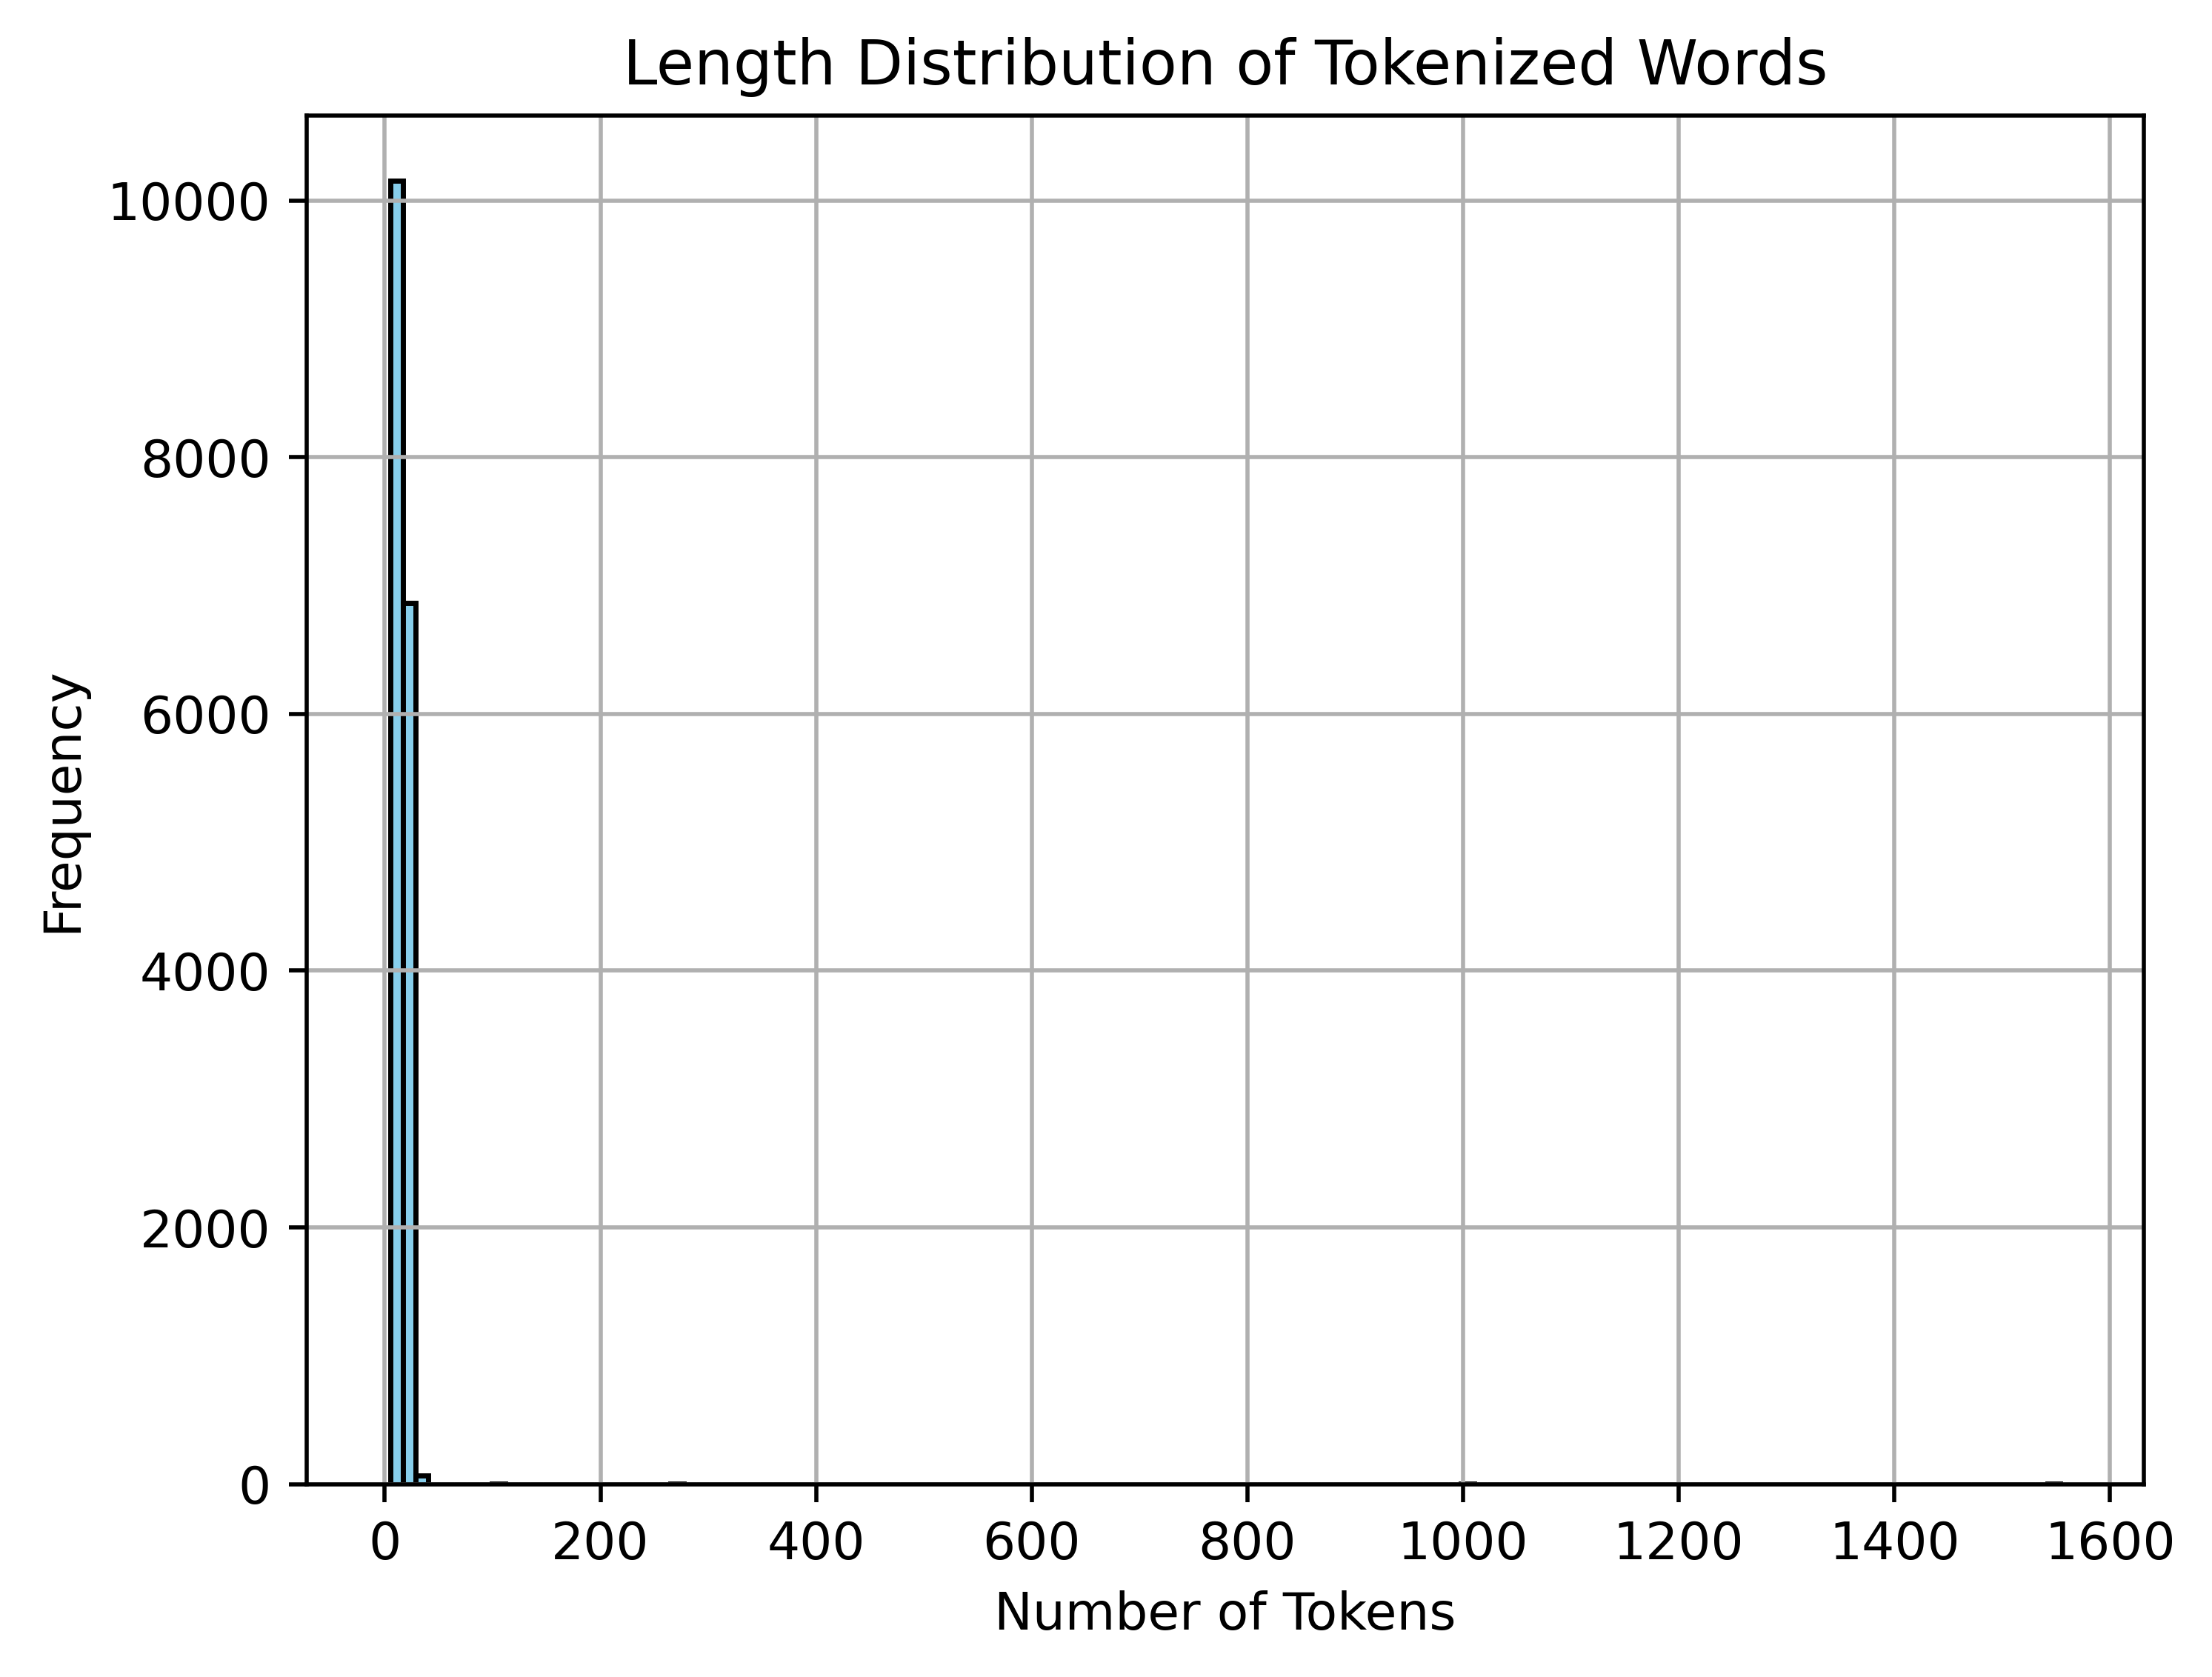

In [8]:
plt.hist(token_lengths, bins=math.ceil(np.sqrt(len(token_lengths))), color='skyblue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Length Distribution of Tokenized Words')
plt.grid(True)
plt.show()

/Users/josh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


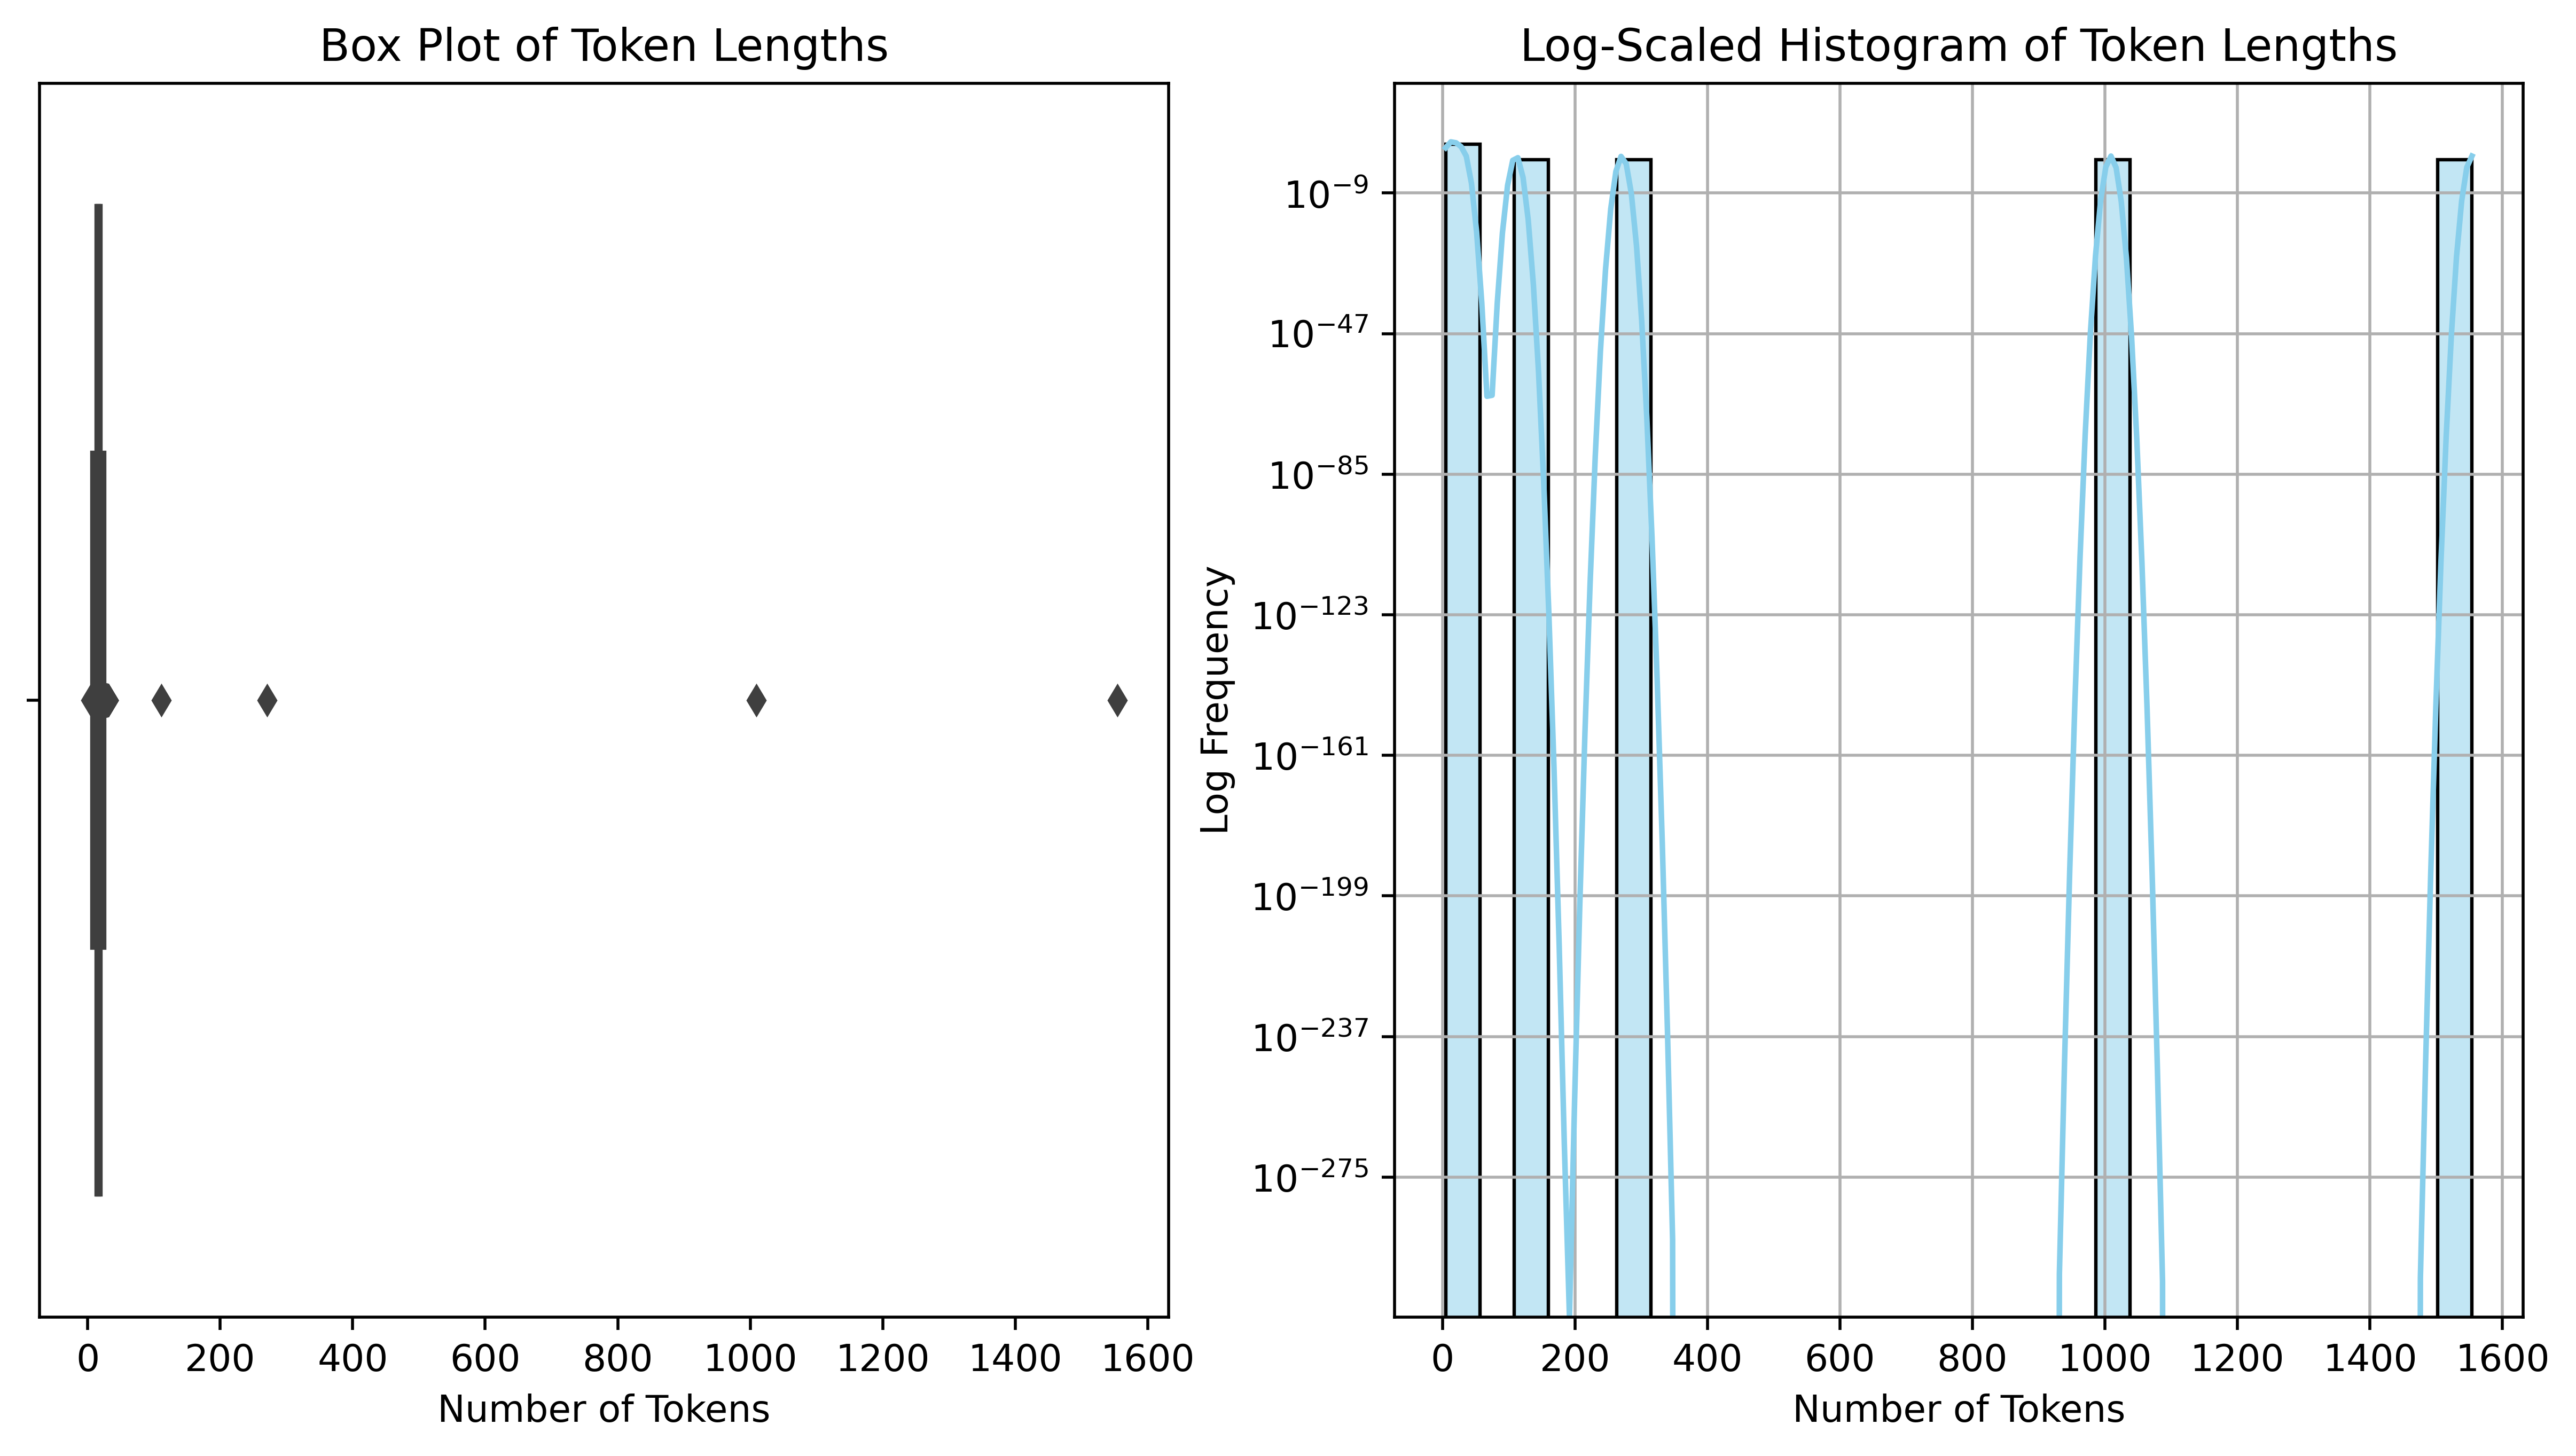

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=token_lengths)
plt.title('Box Plot of Token Lengths')
plt.xlabel('Number of Tokens')

plt.subplot(1, 2, 2)
sns.histplot(token_lengths, bins=30, kde=True, log_scale=(False, True), color='skyblue')
plt.xlabel('Number of Tokens')
plt.ylabel('Log Frequency')
plt.title('Log-Scaled Histogram of Token Lengths')
plt.grid(True)
plt.show()

In [10]:
# Set maximum sequence length based on observed token lengths
# max_sequence_length = int(np.mean(token_lengths)) + int(np.std(token_lengths))
max_sequence_length = np.mean(token_lengths) + np.std(token_lengths)

print(f"Maximum sequence length: {max_sequence_length:4f}")

Maximum sequence length: 30.912780


In [11]:
max_sequence_length = 35

# Pad sequences to the same length for modeling
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='pre')

## Model Building

In [9]:
# Define Convolutional Neural Network (CNN) model for classification
embedding_dim = 100
num_filters = 128
kernel_size = 5
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(np.unique(y_train))

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [10]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7471 - loss: 0.6064 - val_accuracy: 0.9555 - val_loss: 0.1476
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9799 - loss: 0.0635 - val_accuracy: 0.9585 - val_loss: 0.1373
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9924 - loss: 0.0219 - val_accuracy: 0.9672 - val_loss: 0.1516
Epoch 4/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9946 - loss: 0.0163 - val_accuracy: 0.9620 - val_loss: 0.1693
Epoch 5/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.9570 - val_loss: 0.2438
Epoch 6/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9981 - loss: 0.0080 - val_accuracy: 0.9582 - val_loss: 0.2015
Epoch 7/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9970 - loss: 0.0110 - val_accuracy: 0.9658 - val_loss: 0.2134
Epoch 8/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accur

## Model Evaluation

In [11]:
# Evaluate model on test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nTest Accuracy: {accuracy}")

  1/134 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9375 - loss: 1.0477

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.2466

Test Accuracy: 0.9672361612319946


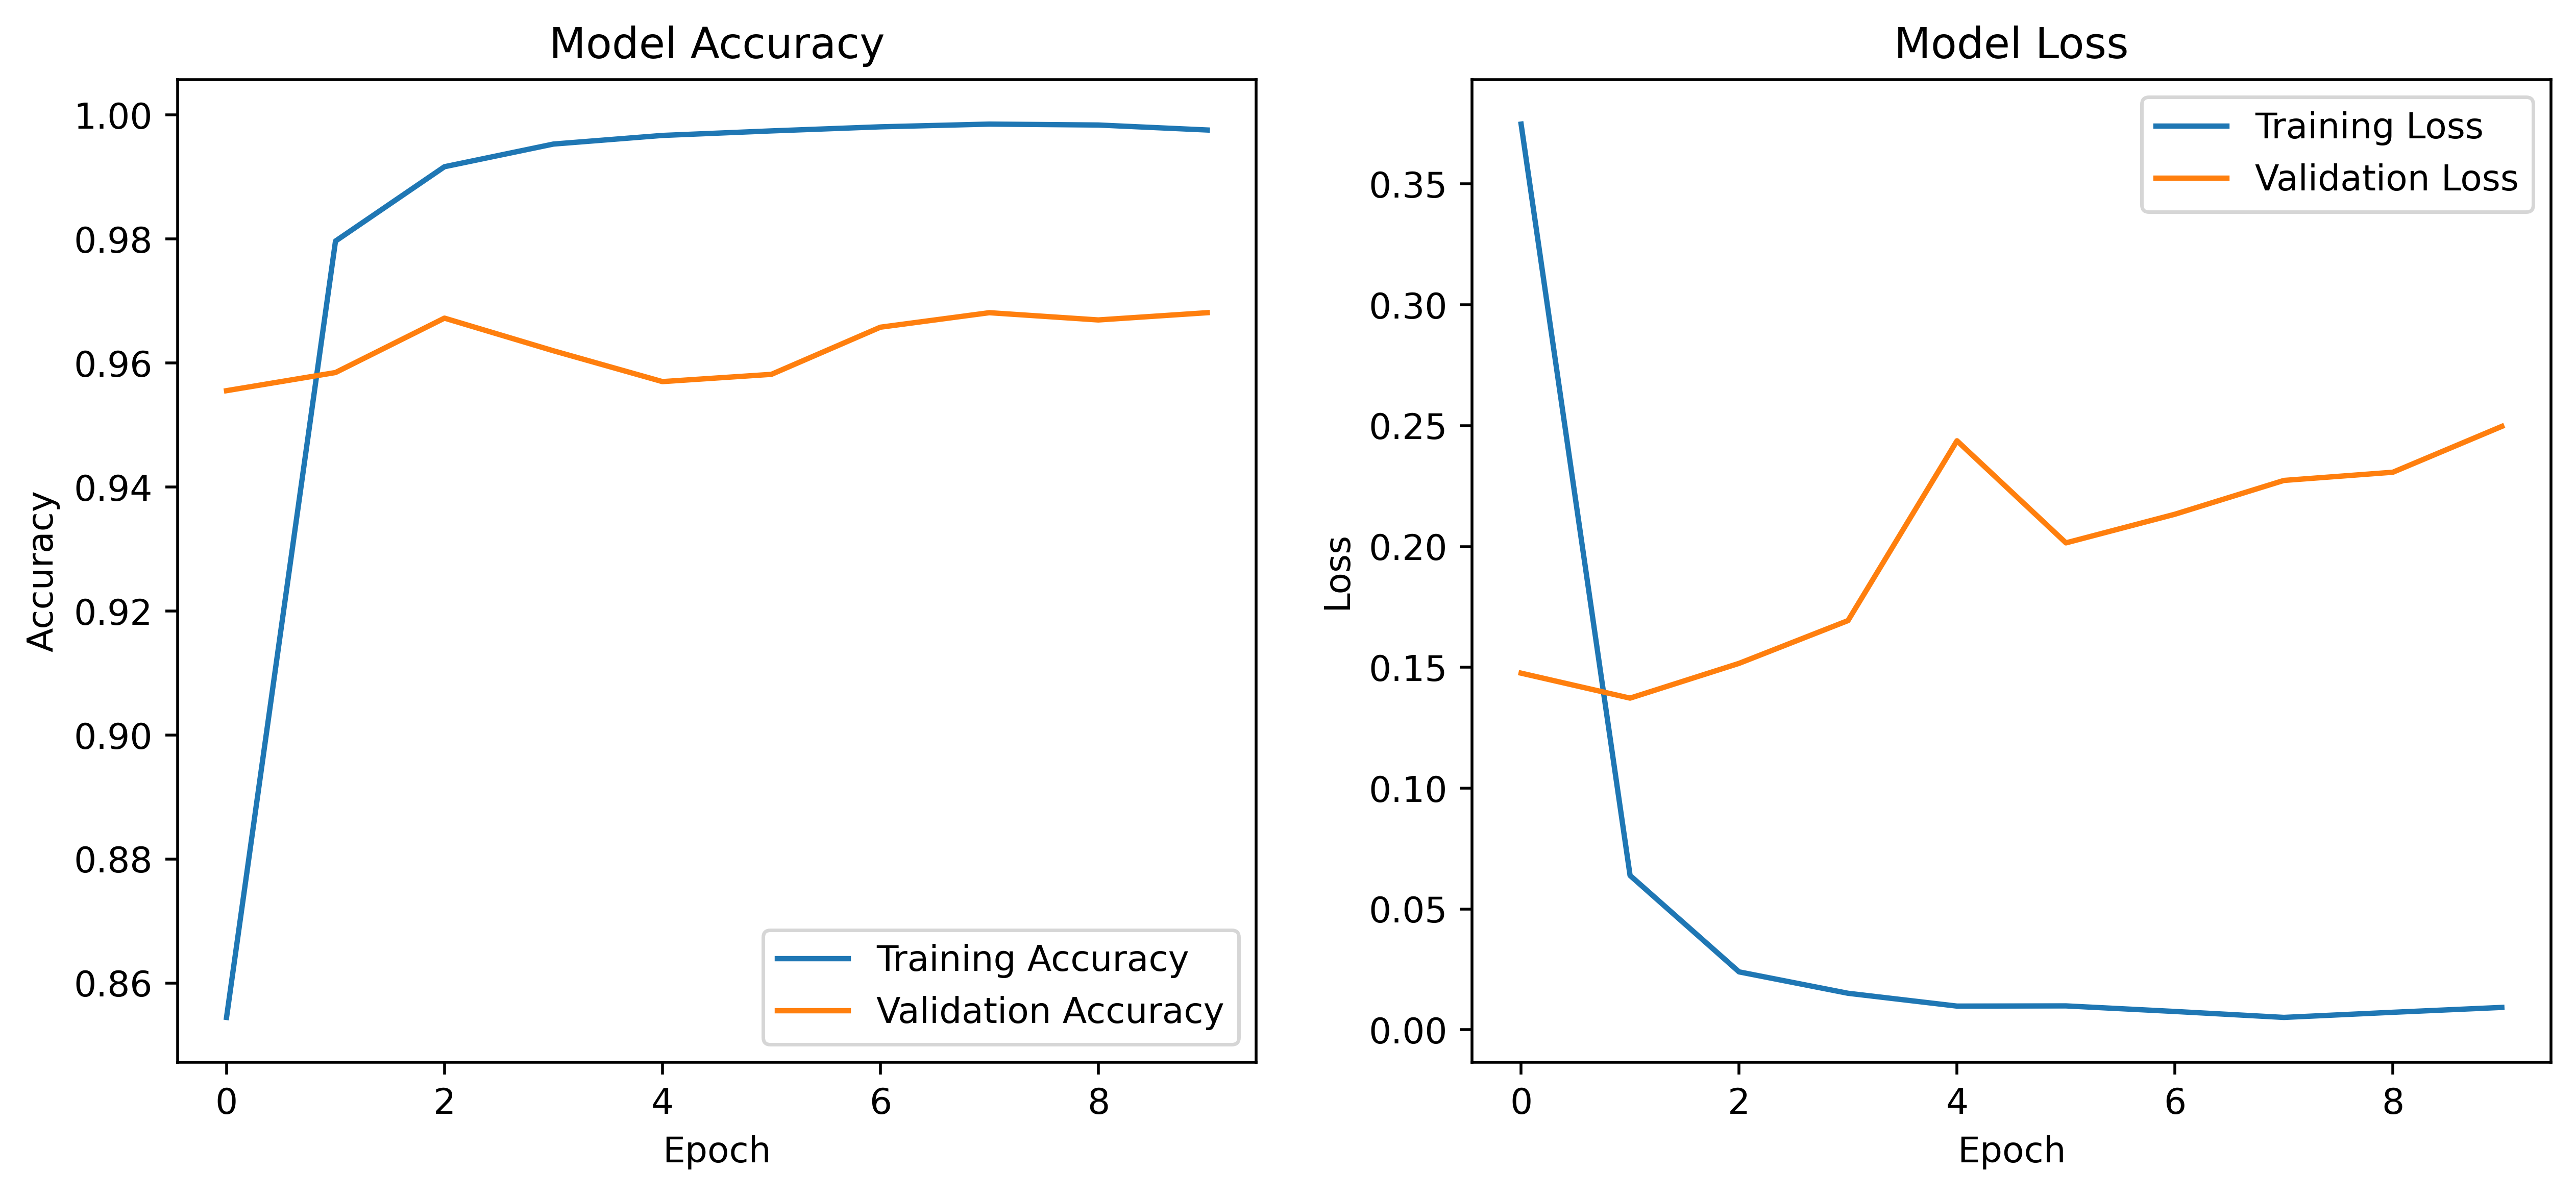

In [12]:
# Model Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
# Generate predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


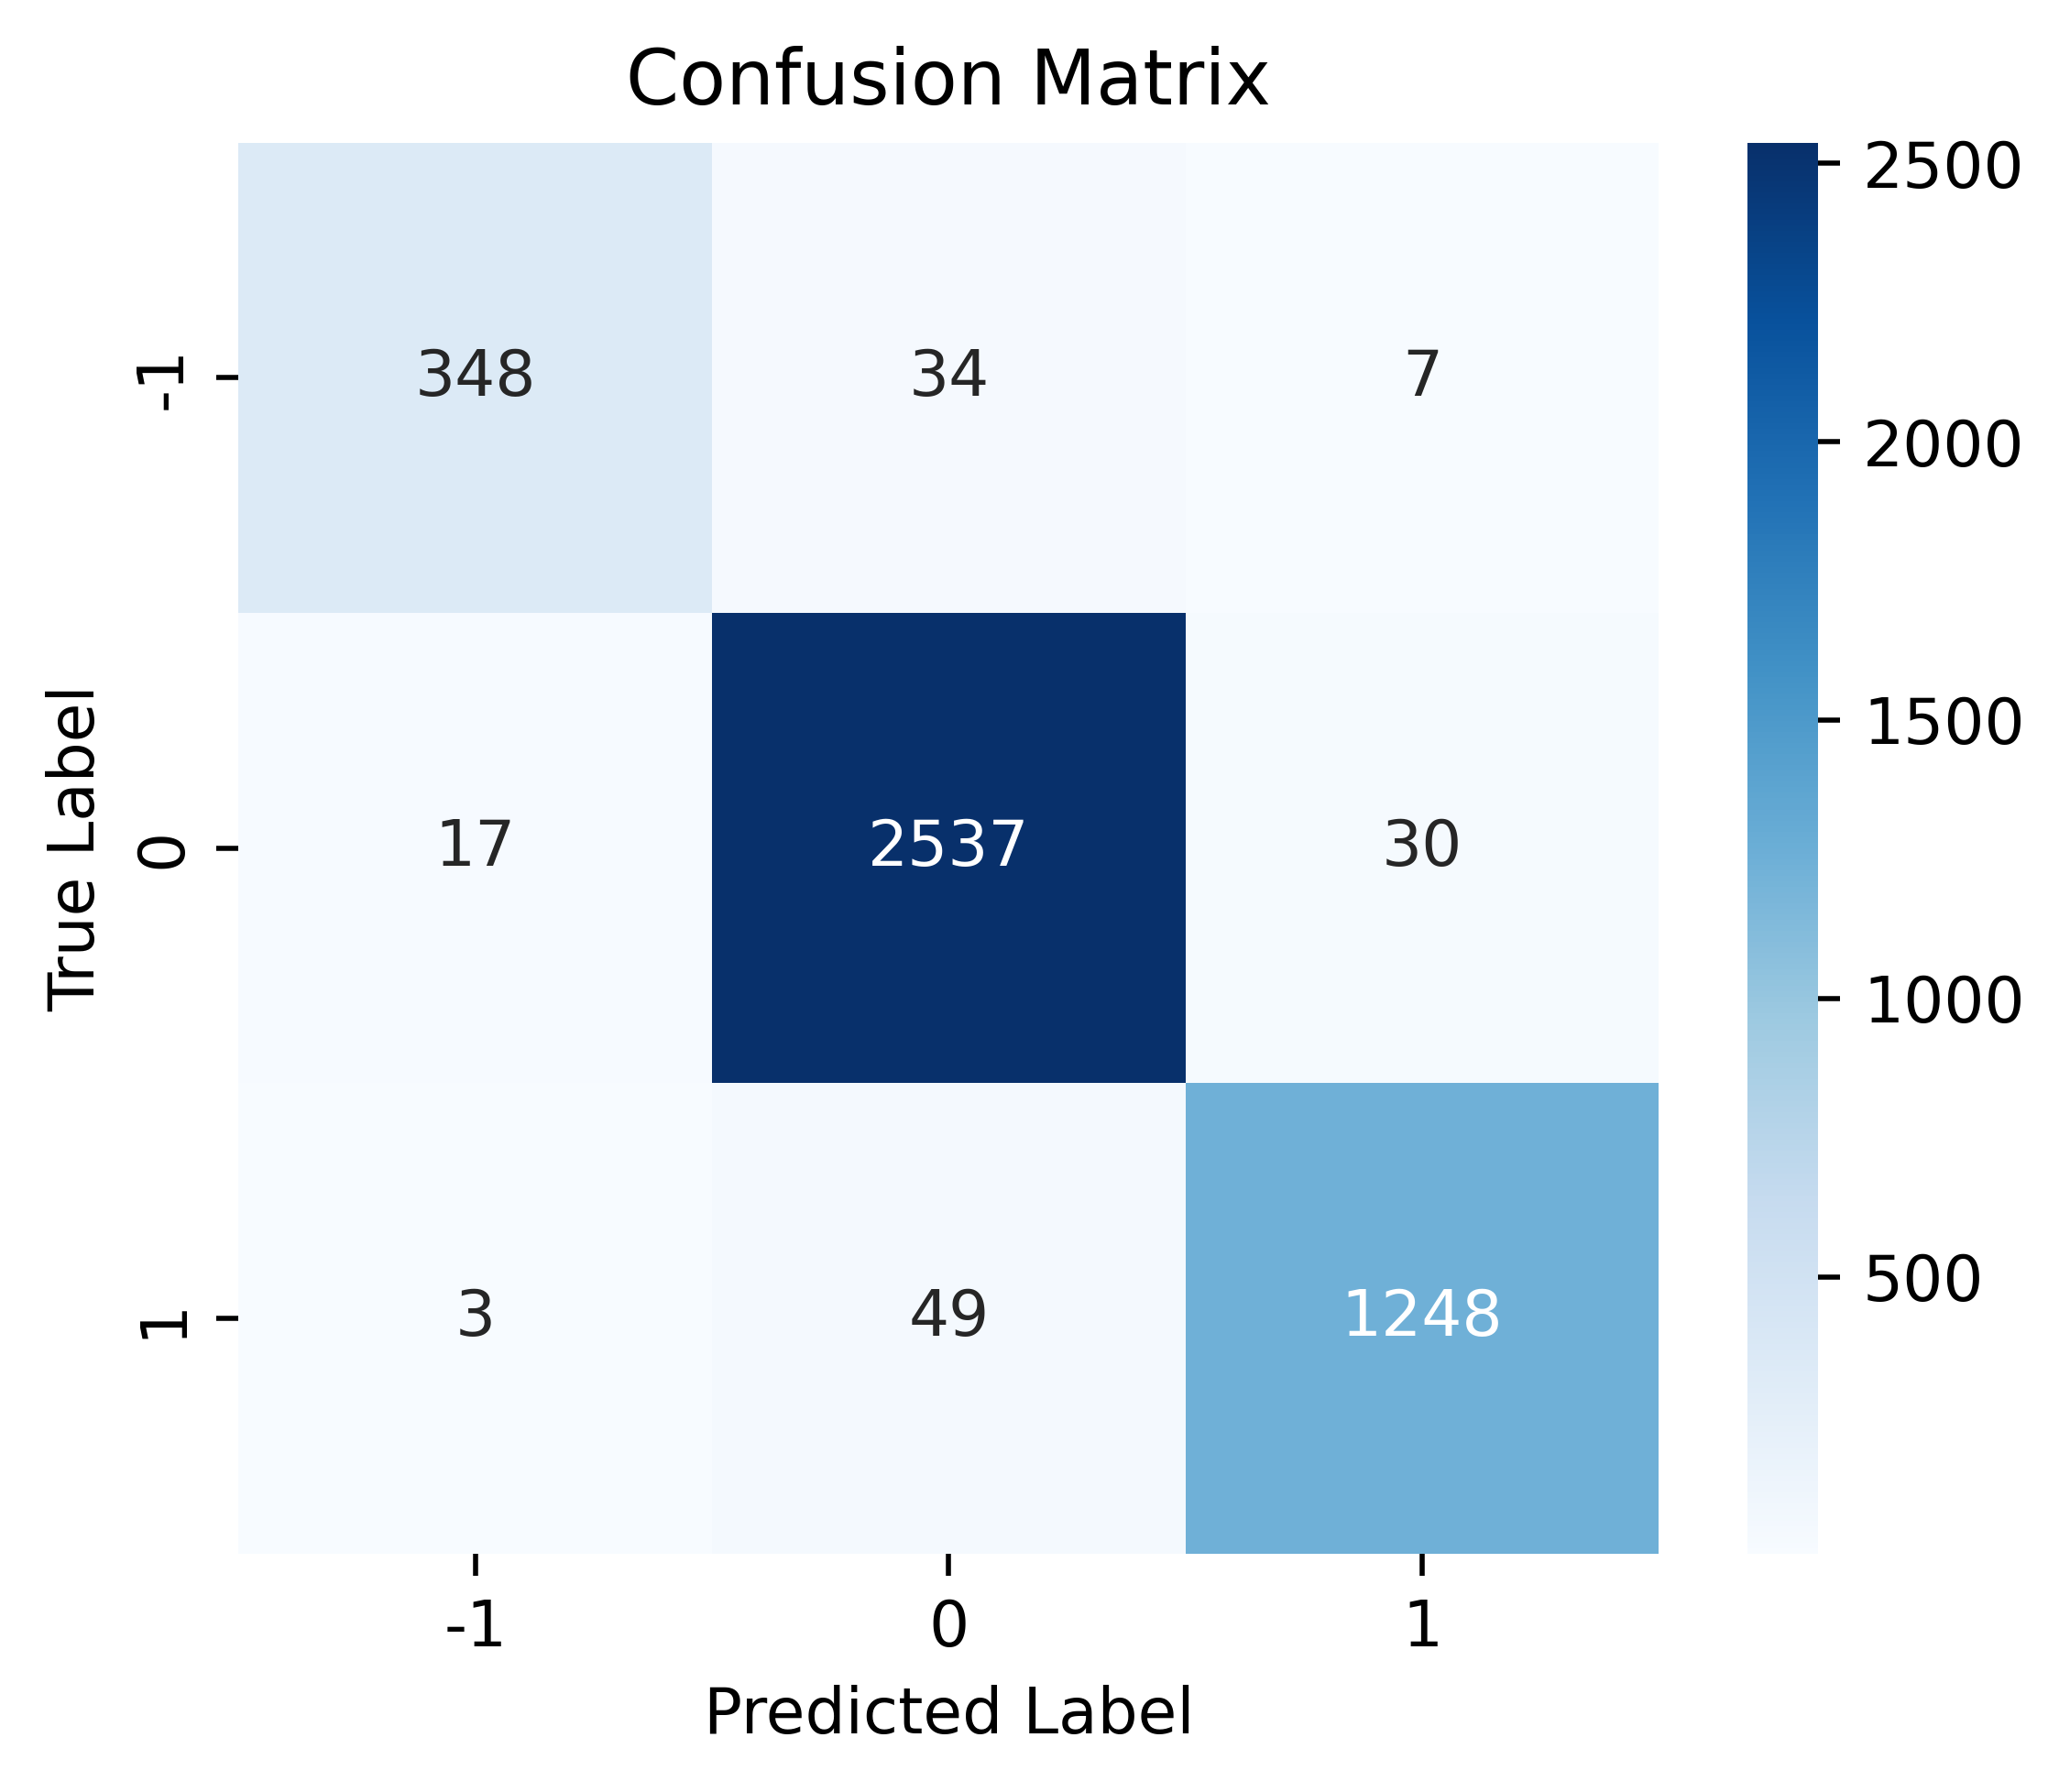

In [14]:
# Generate confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       389
           1       0.97      0.98      0.98      2584
           2       0.97      0.96      0.97      1300

    accuracy                           0.97      4273
   macro avg       0.96      0.95      0.95      4273
weighted avg       0.97      0.97      0.97      4273



## Model Optimization

### K-Fold Cross-Validation

In [14]:
def build_sentiment_analysis_model(vocab_size, embedding_dim, num_filters, kernel_size, pool_size, dense_units, num_classes):
    """
    Constructs a convolutional neural network model for sentiment analysis.
    
    Parameters:
    - vocab_size: int, size of the vocabulary.
    - embedding_dim: int, dimension of the embedding layer.
    - num_filters: int, number of filters for each convolutional layer.
    - kernel_size: int, size of the convolution kernel.
    - pool_size: int, size of the pooling window.
    - dense_units: int, number of neurons in the dense layer.
    - num_classes: int, number of output classes.
    
    Returns:
    - model: a Sequential model object.
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("Training set shape:", X_train_fold.shape)
print("Validation set shape:", X_val_fold.shape)
print("Training labels shape:", y_train_fold.shape)
print("Validation labels shape:", y_val_fold.shape)

# Ensure that none of the datasets are empty
assert X_train_fold.size > 0, "Training set is empty"
assert X_val_fold.size > 0, "Validation set is empty"
assert y_train_fold.size > 0, "Training labels set is empty"
assert y_val_fold.size > 0, "Validation labels set is empty"

# Adjust batch_size if necessary
batch_size = 64
if len(X_train_fold) < batch_size:
    batch_size = len(X_train_fold)
    print("Warning: Adjusted batch size to:", batch_size)

# Proceed with model training
history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=batch_size, validation_data=(X_val_fold, y_val_fold))


# Define constants for model parameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
NUM_FILTERS = 64
KERNEL_SIZE = 3
POOL_SIZE = 3
DENSE_UNITS = 64
NUM_CLASSES = 10
K_FOLDS = 10

# Initialize lists to store per-fold histories
fold_accuracies = []
fold_val_accuracies = []
fold_losses = []
fold_val_losses = []

# Initialize KFold object with random shuffling
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for train_indices, val_indices in kfold.split(X_train_pad):
    X_train_fold = X_train_pad[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train_pad[val_indices]
    y_val_fold = y_train[val_indices]

    model = build_sentiment_analysis_model(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, KERNEL_SIZE, POOL_SIZE, DENSE_UNITS, NUM_CLASSES)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Training the model
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold))
    
    # Collecting accuracy and loss history
    fold_accuracies.append(history.history['accuracy'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    fold_losses.append(history.history['loss'])
    fold_val_losses.append(history.history['val_loss'])

Training set shape: (15383, 35)
Validation set shape: (1709, 35)
Training labels shape: (15383,)
Validation labels shape: (1709,)
Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9696 - val_loss: 0.1503
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9713 - val_loss: 0.1539
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9684 - val_loss: 0.1754
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9702 - val_loss: 0.1834
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 2.7976e-04 - val_accuracy: 0.9696 - val_loss: 0.1776
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 9.5075e-05 - val_accuracy: 0.9696 - val_loss: 0.1828
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 5.2047e-05 - v

In [15]:
# Calculating mean of metrics across all folds
mean_accuracy = np.mean(fold_accuracies, axis=0)
mean_val_accuracy = np.mean(fold_val_accuracies, axis=0)
mean_loss = np.mean(fold_losses, axis=0)
mean_val_loss = np.mean(fold_val_losses, axis=0)

# Printing the mean accuracy and loss
print(f"Mean Training Accuracy: {mean_accuracy[-1]:.6f}")
print(f"Mean Validation Accuracy: {mean_val_accuracy[-1]:.6f}")
print(f"Mean Training Loss: {mean_loss[-1]:.6f}")
print(f"Mean Validation Loss: {mean_val_loss[-1]:.6f}")

Mean Training Accuracy: 0.999473
Mean Validation Accuracy: 0.964663
Mean Training Loss: 0.001619
Mean Validation Loss: 0.215637


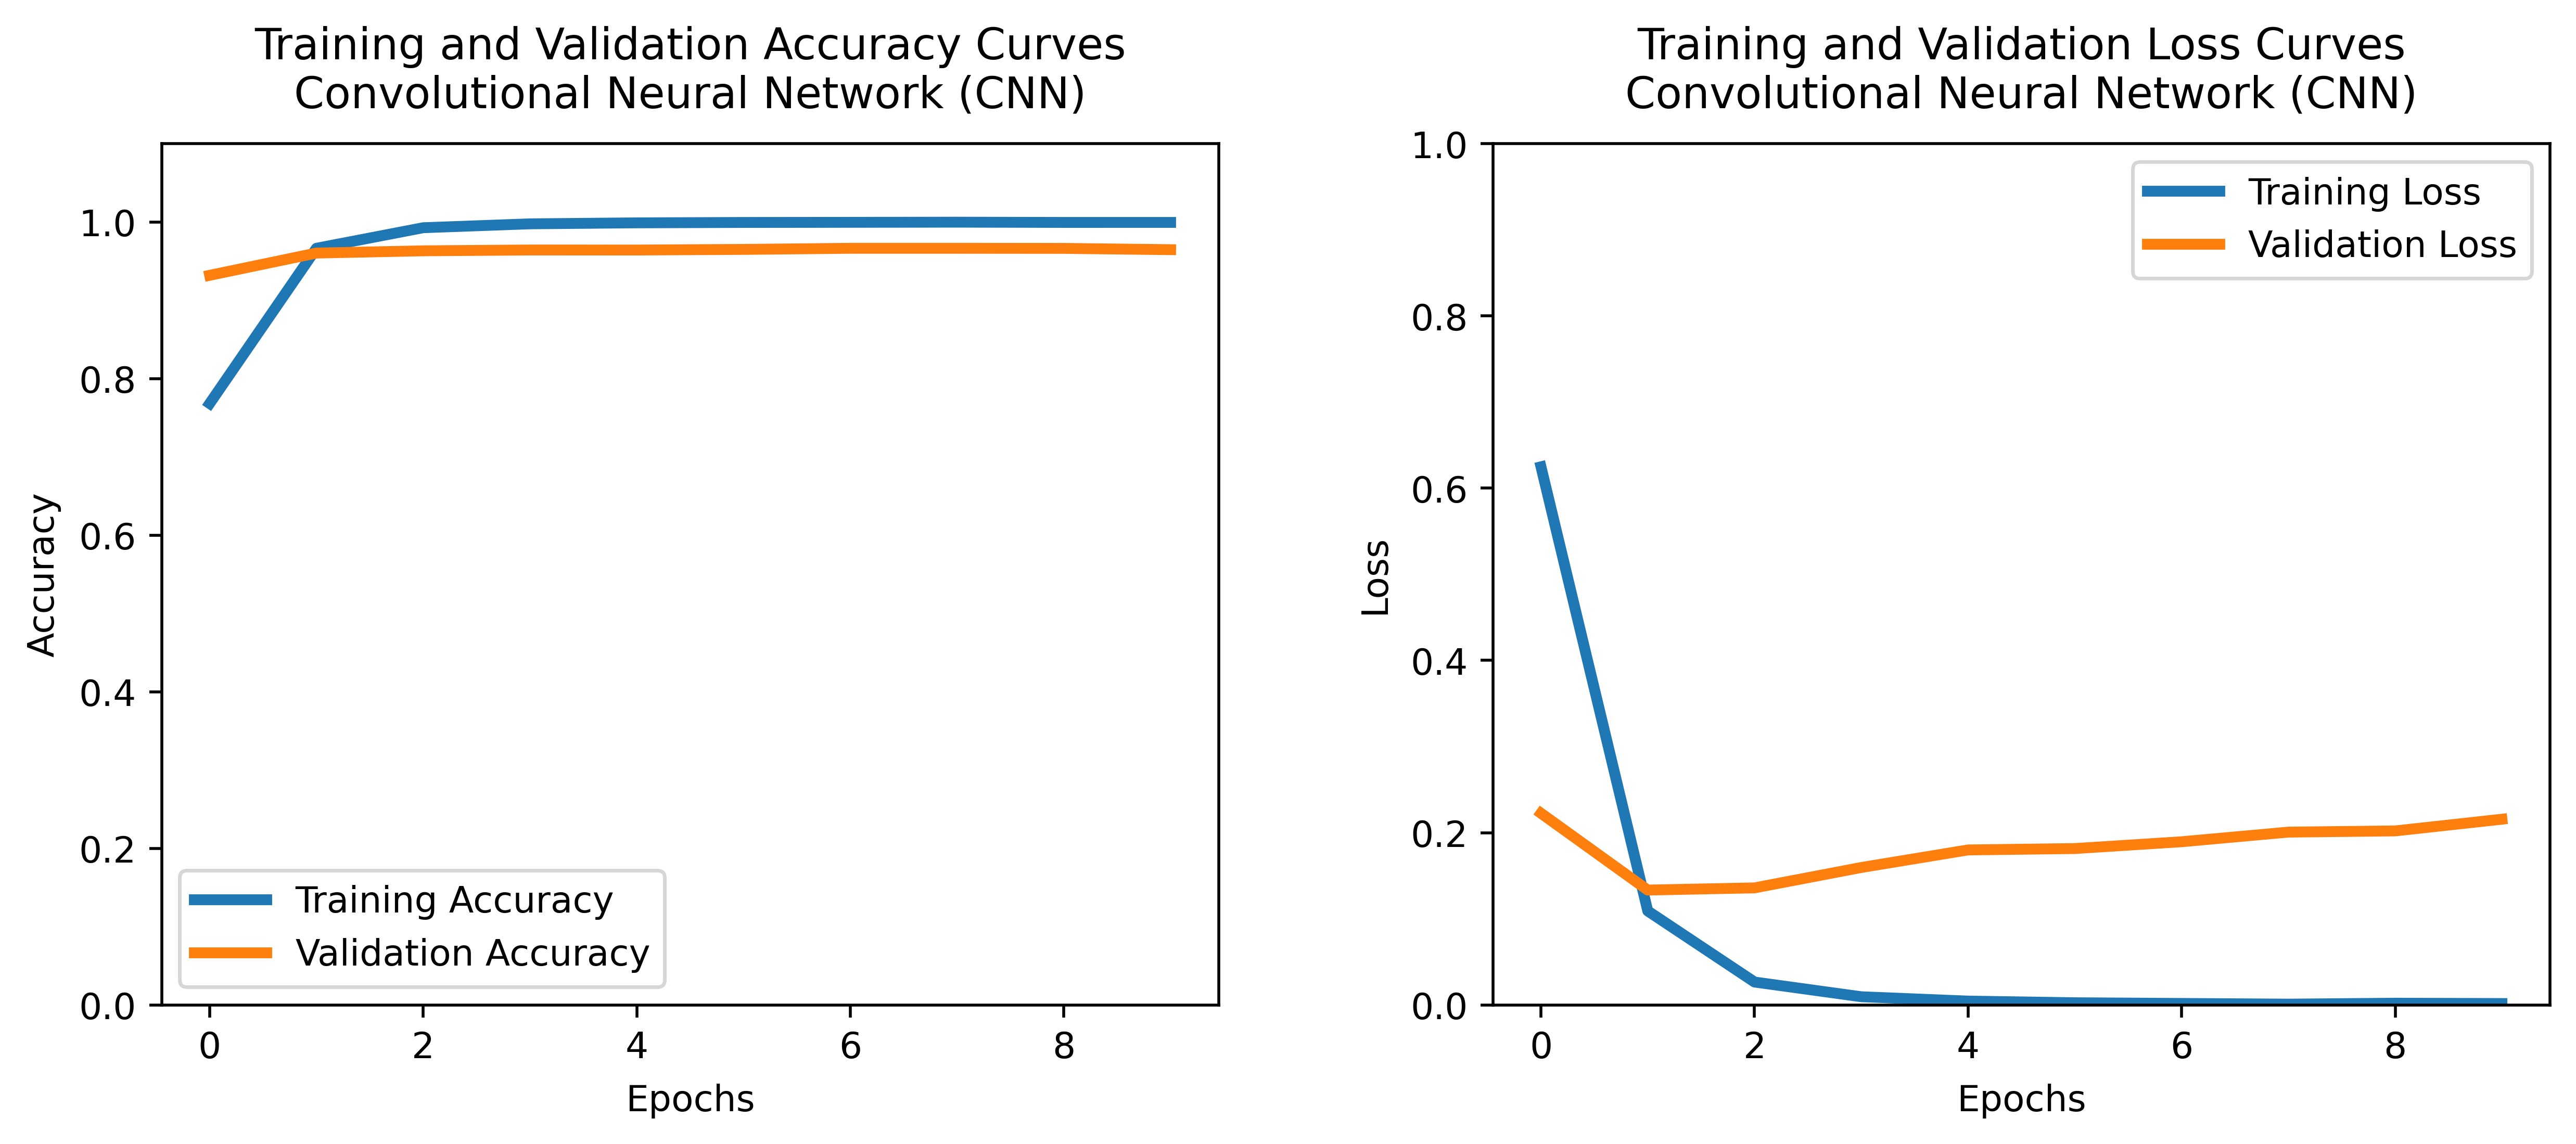

In [16]:
# Plotting model accuracy and loss
plt.figure(figsize=(10, 4.5))

model = "Convolutional Neural Network (CNN)"

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(mean_accuracy, label='Training Accuracy', linewidth=3)
plt.plot(mean_val_accuracy, label='Validation Accuracy', linewidth=3)
plt.title(f'Training and Validation Accuracy Curves\n{model}', fontsize=12, pad=10)
plt.ylabel('Accuracy', labelpad=5)
plt.xlabel('Epochs', labelpad=5)
plt.ylim(0, 1.1)  # Setting y-axis scale from 0 to 1
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(mean_loss, label='Training Loss', linewidth=3)
plt.plot(mean_val_loss, label='Validation Loss', linewidth=3)
plt.title(f'Training and Validation Loss Curves\n{model}', fontsize=12, pad=10)
plt.ylabel('Loss', labelpad=5)
plt.xlabel('Epochs', labelpad=5)
plt.ylim(0, 1)  # Setting y-axis scale from 0 to 1
plt.legend()

plt.subplots_adjust(wspace=3)  # Adjust the width space between subplots

plt.tight_layout()

plt.savefig(f"../Figs/{model}_DS1_Accuracy_Loss_Folds.pdf")

plt.show()